In [3]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

## Function: download_financials

This function downloads financial statements data and OHLC (Open, High, Low, Close) data using the `yfinance` library, merges them, and returns a combined DataFrame.

### Parameters:
- `ticker` (str): The ticker symbol of the asset for which financial data is to be retrieved.
- `start_date` (str): The start date for fetching financial data in the format "YYYY-MM-DD".
- `end_date` (str): The end date for fetching financial data in the format "YYYY-MM-DD".

### Returns:
- `combined_data` (DataFrame): A DataFrame containing the combined financial statements data and OHLC data for the specified ticker.

----

### 1. Annual Statements for Last 4 Years

You can use the function `download_financials` to retrieve annual financial statements data for the last four years.

#### Considerations:
- **Comprehensive Overview**: Annual financial statements provide a comprehensive overview of a company's performance over a year.
- **Long-Term Trends**: Useful for identifying long-term trends and patterns in a company's financial performance.
- **Strategic Analysis**: Often used for strategic analysis and decision-making, such as evaluating investment opportunities.
- **Investment Horizon**: Suitable for investors with a long-term investment horizon.

----

### 2. Quarterly Statements for Last 5 Quarters

Alternatively, you can use the function `download_quarterly_financials` to retrieve quarterly financial statements data for the last five quarters. 

#### Considerations:
- **Timely Updates**: Quarterly financial statements offer more frequent updates on a company's financial performance.
- **Short-Term Analysis**: Valuable for short-term analysis and monitoring of recent performance trends.
- **Market Sentiment**: Can influence market sentiment and investor perception due to recent developments.
- **Risk Management**: Useful for assessing short-term risks and volatility.
- **Trading Strategies**: May be used by traders and active investors to identify short-term trading opportunities.

In [6]:
def download_financials(ticker, quarterly=False):
    """
    Downloads financial statements data and OHLC data using yfinance,
    merges them, and returns a combined DataFrame.

    Parameters:
    ticker (str): The ticker symbol of the asset for which financial data is to be retrieved.
    quarterly (bool): Specifies whether to retrieve quarterly financial statements data. Default is False (retrieve yearly data).

    Returns:
    financial_data (DataFrame): A DataFrame containing the combined financial statements data and OHLC data for the specified ticker.
    """
    # Determine date range based on quarterly parameter
    if quarterly:
        end_date = datetime.today().strftime("%Y-%m-%d")
        start_date = (datetime.today() - timedelta(days=1.25*365)).strftime("%Y-%m-%d") # Five quarters back
    else:
        end_date = datetime.today().strftime("%Y-%m-%d")
        start_date = (datetime.today() - timedelta(days=365*4)).strftime("%Y-%m-%d")

    # Download OHLC data using yfinance
    ohlc_data = yf.download(ticker, start=start_date, end=end_date)

    # Download financial statements data using yfinance
    if quarterly:
        financials_income = yf.Ticker(ticker).quarterly_income_stmt.transpose()[::-1]
        financials_balance_sheet = yf.Ticker(ticker).quarterly_balance_sheet.transpose()[::-1]
        financials_cashflow = yf.Ticker(ticker).quarterly_cashflow.transpose()[::-1]
    else:
        financials_income = yf.Ticker(ticker).financials.transpose()[::-1]
        financials_balance_sheet = yf.Ticker(ticker).balance_sheet.transpose()[::-1]
        financials_cashflow = yf.Ticker(ticker).cashflow.transpose()[::-1]

    # Merge the financial statements data into a single DataFrame
    financials = pd.concat([financials_income, financials_balance_sheet, financials_cashflow], axis=1)
    financials = financials.rename_axis('Date')
    
    # Merge datasets based on the Date column using nearest available adjusted close price
    financial_data = pd.merge_asof(financials, ohlc_data['Adj Close'], on='Date', direction='nearest')
    
    # Set Date column as index in the financial_data DataFrame
    financial_data.set_index('Date', inplace=True)

    # Fill NaN values with zeros
    financial_data.fillna(0, inplace=True)
        
    return financial_data

### Example 1: Printing Merged Financial Data

In [25]:
financial_data = download_financials("AAPL", quarterly=True)
print(financial_data)

[*********************100%%**********************]  1 of 1 completed

            Tax Effect Of Unusual Items  Tax Rate For Calcs  \
Date                                                          
2022-12-31                          0.0            0.158000   
2023-03-31                          0.0            0.149000   
2023-06-30                          0.0            0.125000   
2023-09-30                          0.0            0.149715   
2023-12-31                          0.0            0.159000   

            Normalized EBITDA  \
Date                            
2022-12-31       3.893200e+10   
2023-03-31       3.221000e+10   
2023-06-30       2.678300e+10   
2023-09-30       3.065300e+10   
2023-12-31       4.322100e+10   

            Net Income From Continuing Operation Net Minority Interest  \
Date                                                                     
2022-12-31                                       2.999800e+10            
2023-03-31                                       2.416000e+10            
2023-06-30                    

### Example 2: Data Merge Sanity Check Plot

This plot visually confirms the alignment of financial statement dates with corresponding adjusted close prices. It ensures the merging process was successful and that financial statements data is correctly paired with the nearest available adjusted close prices.

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


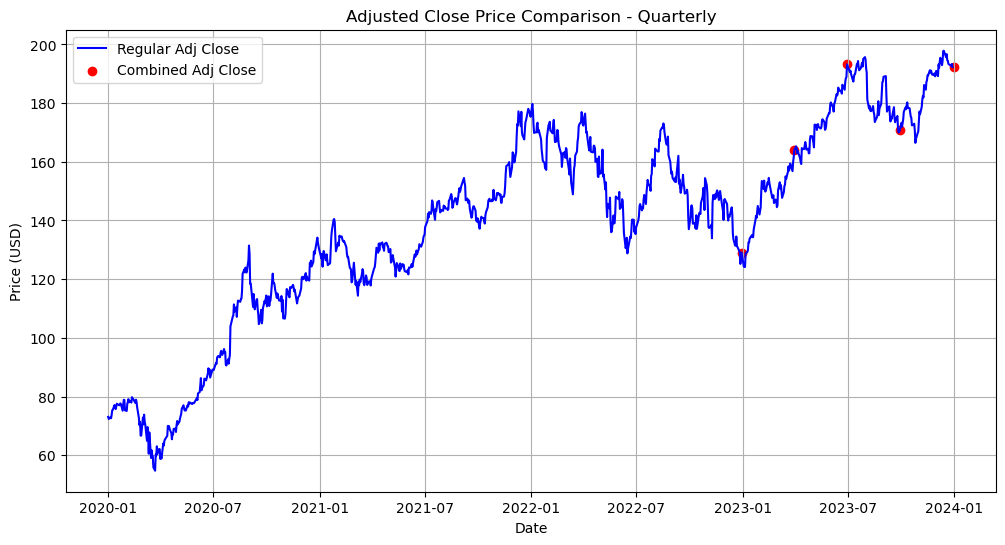

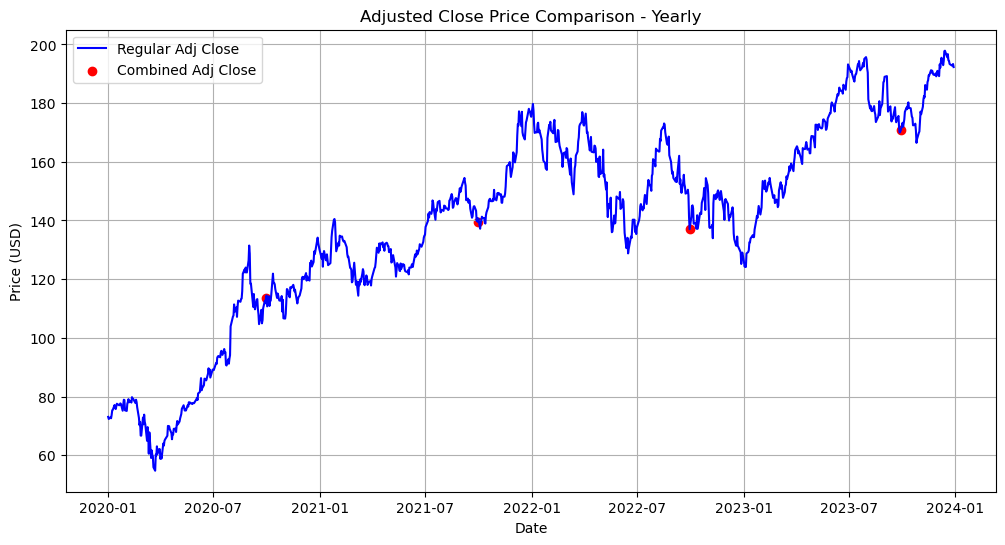

In [9]:
def plot_combined_data_with_regular(adj_close, combined_adj_close, frequency):
    """
    Plot combined adjusted close alongside regular adjusted close.

    Parameters:
    adj_close (Series): Regular adjusted close data.
    combined_adj_close (DataFrame): Combined adjusted close data.
    frequency (str): Frequency of the data (e.g., "Quarterly", "Yearly").
    """
    plt.figure(figsize=(12, 6))
    plt.plot(adj_close.index, adj_close, label='Regular Adj Close', color='blue')
    plt.scatter(combined_adj_close.index, combined_adj_close, label='Combined Adj Close', color='red')
    plt.title(f'Adjusted Close Price Comparison - {frequency}')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Retrieve regular adjusted close data
ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2024-01-01"
adj_close = yf.download(ticker, start=start_date, end=end_date)['Adj Close']

# Retrieve combined data for both scenarios: quarterly and yearly
financial_data_quarterly = download_financials(ticker, quarterly=True)
financial_data_yearly = download_financials(ticker)

# Plot combined adjusted close alongside regular adjusted close for both scenarios
plot_combined_data_with_regular(adj_close, financial_data_quarterly['Adj Close'], "Quarterly")
plot_combined_data_with_regular(adj_close, financial_data_yearly['Adj Close'], "Yearly")

### Understanding Financial Statement Structure

In this section, we print the first column of each financial statement without transposing the data. By doing so, users can easily examine the structure and names of the financial statement items. This allows users to choose specific data points for their analysis or gain insights into the composition of each financial statement.

In [12]:
# Define the ticker symbol
ticker = "AAPL"

# Download all financial statements data using yfinance
financials_income = yf.Ticker(ticker).financials
financials_balance_sheet = yf.Ticker(ticker).balance_sheet
financials_cashflow = yf.Ticker(ticker).cashflow

#### Income Statement

In [15]:
# Print the first column of each financial statement
print("Income Statement:")
print(financials_income.iloc[:, 0])  # Print the first column

Income Statement:
Tax Effect Of Unusual Items                                              0.0
Tax Rate For Calcs                                                     0.147
Normalized EBITDA                                             129188000000.0
Net Income From Continuing Operation Net Minority Interest     96995000000.0
Reconciled Depreciation                                        11519000000.0
Reconciled Cost Of Revenue                                    214137000000.0
EBITDA                                                        129188000000.0
EBIT                                                          117669000000.0
Net Interest Income                                             -183000000.0
Interest Expense                                                3933000000.0
Interest Income                                                 3750000000.0
Normalized Income                                              96995000000.0
Net Income From Continuing And Discontinued Operation     

#### Balance Sheet

In [18]:
pd.set_option('display.max_rows', None)
print("\nBalance Sheet:")
print(financials_balance_sheet.iloc[:, 0])  # Print the first column


Balance Sheet:
Treasury Shares Number                                            0.0
Ordinary Shares Number                                  15550061000.0
Share Issued                                            15550061000.0
Net Debt                                                81123000000.0
Total Debt                                             111088000000.0
Tangible Book Value                                     62146000000.0
Invested Capital                                       173234000000.0
Working Capital                                         -1742000000.0
Net Tangible Assets                                     62146000000.0
Common Stock Equity                                     62146000000.0
Total Capitalization                                   157427000000.0
Total Equity Gross Minority Interest                    62146000000.0
Stockholders Equity                                     62146000000.0
Gains Losses Not Affecting Retained Earnings           -11452000000.0
Othe

#### Cash Flow Statement

In [21]:
print("\nCash Flow Statement:")
print(financials_cashflow.iloc[:, 0])  # Print the first column


Cash Flow Statement:
Free Cash Flow                                     99584000000.0
Repurchase Of Capital Stock                       -77550000000.0
Repayment Of Debt                                 -11151000000.0
Issuance Of Debt                                    5228000000.0
Issuance Of Capital Stock                                    NaN
Capital Expenditure                               -10959000000.0
Interest Paid Supplemental Data                     3803000000.0
Income Tax Paid Supplemental Data                  18679000000.0
End Cash Position                                  30737000000.0
Beginning Cash Position                            24977000000.0
Changes In Cash                                     5760000000.0
Financing Cash Flow                              -108488000000.0
Cash Flow From Continuing Financing Activities   -108488000000.0
Net Other Financing Charges                        -6012000000.0
Cash Dividends Paid                               -15025000000.0
Com

----